In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import test_s_curve, hhRNADataset, hhATACDataset, test_paul, symsim_batches, cardiacRNADataset, cardiacATACDataset

from utils import *
import model.loss as loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    
    DPT1 = torch.FloatTensor(DPT1).to(device)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT2 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    
    DPT2 = torch.FloatTensor(DPT2).to(device)

In [3]:
import importlib
importlib.reload(loss)

<module 'model.loss' from '/storage/hive/project/cse-vuduc/zzhang834/JointTI/model/loss.py'>

In [34]:
def train_unpaired_mmd(model_rna, model_atac, data_loader_rna, data_loader_atac, diff_sim_rna, diff_sim_atac, n_epochs = 50, lamb_r = 1, lamb_d = 1, lamb_mmd = 1):
    
    for epoch in range(n_epochs):
        iteration = max(len(data_loader_rna), len(data_loader_atac))
        for data in zip(data_loader_rna, data_loader_atac):
            data_rna, data_atac = data
            
            batch_cols_rna = data_rna['index'].to(device)
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count'].to(device)
            
            batch_cols_atac = data_atac['index'].to(device)
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count'].to(device)

            z_rna = model_rna.encoder(batch_expr_rna)
            batch_expr_r_rna = model_rna.decoder(z_rna)
            train_loss_rna, loss_recon_rna, loss_dist_rna = loss.traj_loss(recon_x = batch_expr_r_rna, x = batch_expr_rna, \
                                                                           z = z_rna, diff_sim = batch_sim_rna, \
                                                                           lamb_recon = lamb_r, lamb_dist = lamb_d, recon_mode = "relative")



            z_atac = model_atac.encoder(batch_expr_atac)
            batch_expr_r_atac = model_atac.decoder(z_atac)

            train_loss_atac, loss_recon_atac, loss_dist_atac = loss.traj_loss(recon_x = batch_expr_r_atac, x = batch_expr_atac, \
                                                                              z = z_atac, diff_sim = batch_sim_atac, \
                                                                              lamb_recon = lamb_r, lamb_dist = lamb_d, recon_mode = "relative")

            train_loss = train_loss_rna + train_loss_atac + lamb_mmd * loss.mmd_loss(z_rna, z_atac)
            
            train_loss.backward()
            
            optimizer_rna.step()
            optimizer_rna.zero_grad()
            optimizer_atac.step()
            optimizer_atac.zero_grad()
            
            # recalculate
            z_rna = model_rna.encoder(batch_expr_rna)
            z_atac = model_atac.encoder(batch_expr_atac)
            E_loss = loss.mmd_loss(z_rna, z_atac)
#             print(E_loss.item())
            E_loss.backward()
            optimizer_rna.step()
            optimizer_atac.step()
            optimizer_rna.zero_grad()
            optimizer_atac.zero_grad()
            
        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item())
            log_D = "mmd loss: {:.5f}".format(E_loss.item())
            print("epoch: ", epoch, log_rna, log_atac, log_D)        


In [35]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 1e-3)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 1e-3)

In [36]:
train_unpaired_mmd(ae1, ae2, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, n_epochs=201, lamb_r = 1, lamb_d = 1, lamb_mmd = 1)


epoch:  0 RNA loss: 12.05418, RNA recon loss: 12.89433, RNA dist loss: -0.84015 ATAC loss: 11.71619, ATAC recon loss: 12.60053, ATAC dist loss: -0.88434 mmd loss: 0.00266
epoch:  10 RNA loss: 0.95741, RNA recon loss: 1.85627, RNA dist loss: -0.89886 ATAC loss: 0.88108, ATAC recon loss: 1.77503, ATAC dist loss: -0.89394 mmd loss: 0.00392
epoch:  20 RNA loss: 0.40055, RNA recon loss: 1.32964, RNA dist loss: -0.92910 ATAC loss: 0.32407, ATAC recon loss: 1.25753, ATAC dist loss: -0.93346 mmd loss: 0.00382
epoch:  30 RNA loss: 0.12269, RNA recon loss: 1.06350, RNA dist loss: -0.94082 ATAC loss: 0.06624, ATAC recon loss: 1.01378, ATAC dist loss: -0.94754 mmd loss: 0.00343
epoch:  40 RNA loss: -0.03193, RNA recon loss: 0.91050, RNA dist loss: -0.94243 ATAC loss: -0.08718, ATAC recon loss: 0.87034, ATAC dist loss: -0.95752 mmd loss: 0.00243
epoch:  50 RNA loss: -0.16442, RNA recon loss: 0.78508, RNA dist loss: -0.94951 ATAC loss: -0.20625, ATAC recon loss: 0.75730, ATAC dist loss: -0.96355 mmd

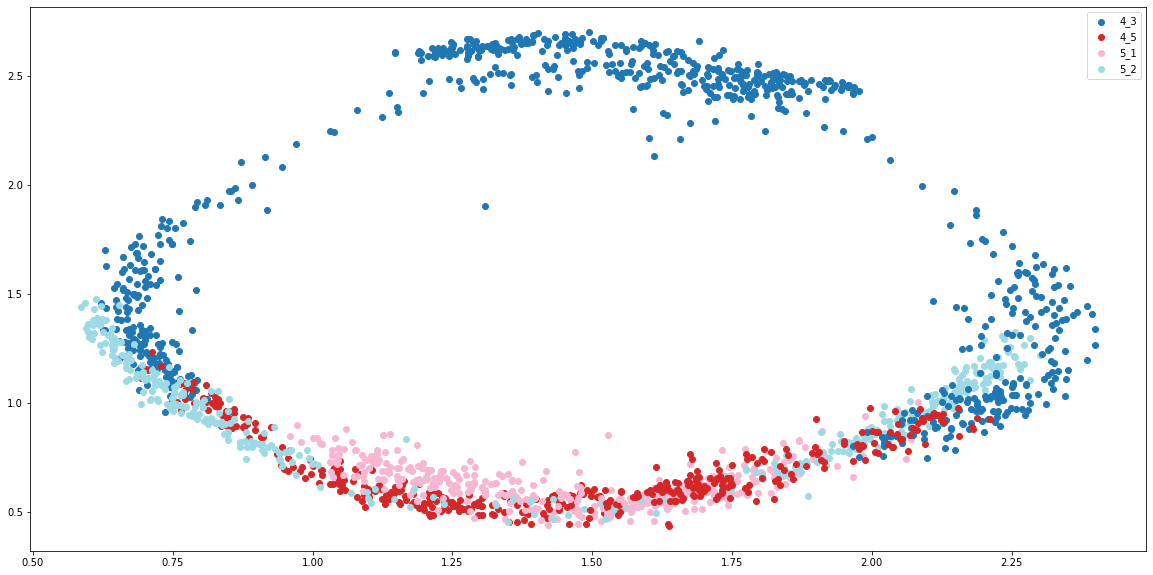

In [39]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)


for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)
# fig.savefig("./result/Symsim/phate_backbones.pdf")

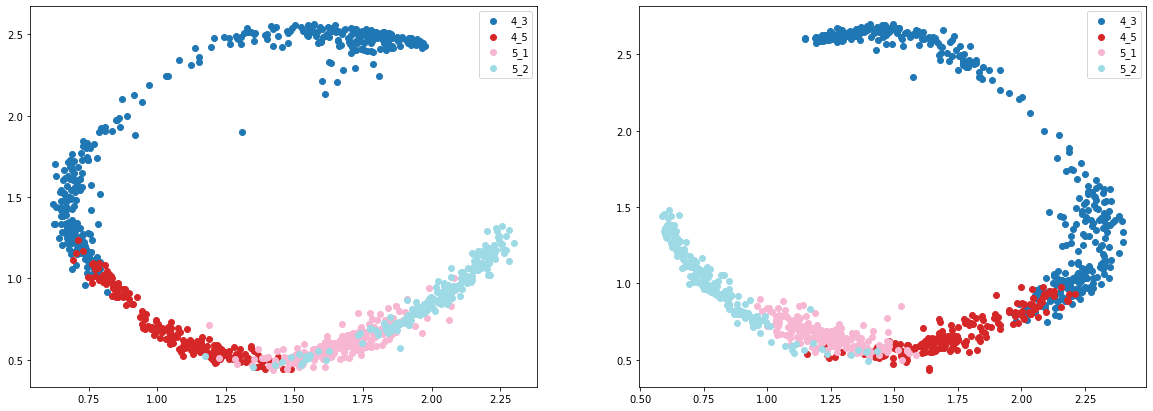

In [40]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1,2)

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[0].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)
axs[0].legend(cluster_types)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[1].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

axs[1].legend(cluster_types)

# fig.savefig("./result/Symsim/phate_backbones_separate.pdf")

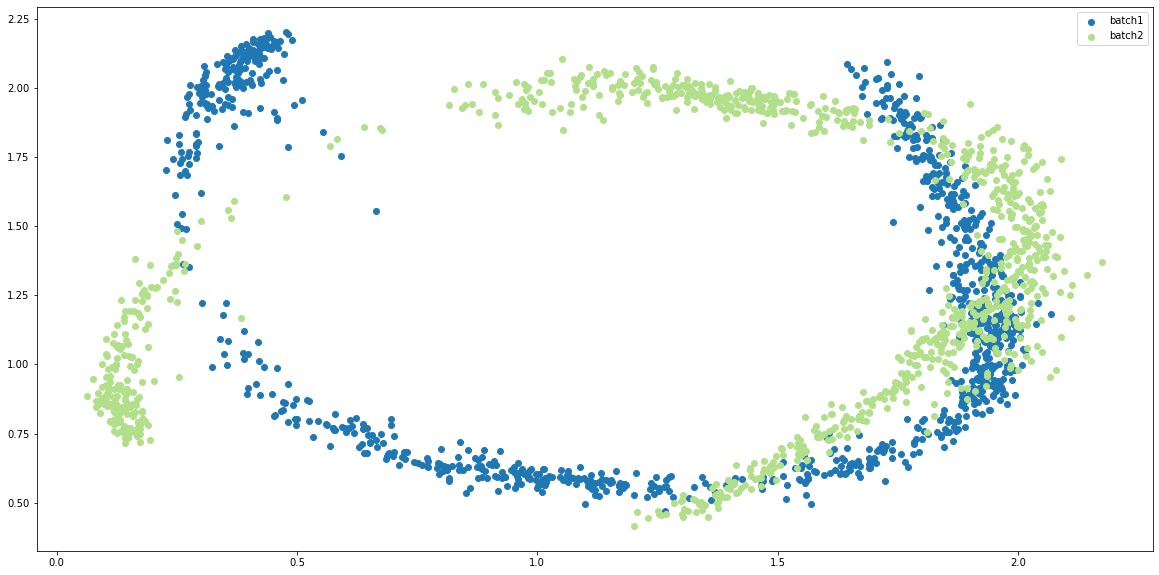

In [33]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
colormap = plt.cm.get_cmap("Paired")

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(1), label = "batch1", alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(2), label = "batch2", alpha = 1)

ax.legend()

# fig.savefig("./result/Symsim/phate_batches_phate.pdf")